# Model Evaluation and Comparison

This notebook compares different Visual Place Recognition models.


## Select Models and Datasets of Interest

In [24]:
from datasets.load_dataset import GardensPointDataset, StLuciaDataset, SFUDataset
from patchnetvlad.tools import PATCHNETVLAD_ROOT_DIR


# List of models to evaluate
models = ['NetVLAD','PatchNetVLAD','BoQ-DinoV2','CosPlace']

# Create dataset objects
datasets = [
    ('GardensPoint', GardensPointDataset()),
    ('StLucia', StLuciaDataset()),
    ('SFU', SFUDataset())
]

## Helper Functions

In [ ]:
import configparser
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import torch
import json
import time

# Import functions from the VPR toolkit
from evaluation.metrics import recallAtK

# Results storage paths
data_path = os.path.join('data/vpr_comparison/')
os.makedirs(data_path, exist_ok=True)
results_path = os.path.join(data_path, 'vpr_comparison_results.json')
timing_path = os.path.join(data_path, 'vpr_timing_results.json')

# Image paths
image_data_paths = 'images/vpr_comparison/'
os.makedirs(image_data_paths, exist_ok=True)

In [26]:
def compute_one_percent_recall(S, GT):
    """
    Compute the 1% recall metric for a given similarity matrix and ground truth.
    """
    # Calculate how many images constitutes 1% of the database
    db_size = S.shape[0]
    k = max(1, int(0.01 * db_size))
    
    # Use the existing recallAtK function
    recall_value = recallAtK(S, GT, K=k)
    
    return recall_value

def save_results(results_dict, timing_dict):
    """Save results and timing to disk"""
    with open(results_path, 'w') as f:
        json.dump(results_dict, f)
    with open(timing_path, 'w') as f:
        json.dump(timing_dict, f)
    print(f"Results and timing data saved")

def load_results():
    """Load results from disk if available"""
    results = defaultdict(dict)
    timing = defaultdict(dict)
    
    if os.path.exists(results_path):
        with open(results_path, 'r') as f:
            results = json.load(f)
    
    if os.path.exists(timing_path):
        with open(timing_path, 'r') as f:
            timing = json.load(f)
            
    return results, timing

def clear_gpu_memory():
    """Clear GPU memory between runs"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

## Evaluate the Models Against Datasets of Interest

In [27]:
def evaluate_model(model_name, dataset, batch_size=4, use_cpu=False):
    """
    Evaluate a VPR model on a specific dataset with memory management options.
    
    Args:
        model_name: Name of the model to evaluate
        dataset: Dataset object
        batch_size: Batch size for processing (smaller = less memory)
        use_cpu: Force CPU usage instead of GPU
    
    Returns:
        Tuple: (recall value, timing dictionary)
    """
    print(f"===== Evaluating {model_name} on {dataset.__class__.__name__} =====")
    
    # Set device
    device = torch.device('cpu') if use_cpu else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize timing dictionary
    timing = {
        'feature_extraction_db': 0,
        'feature_extraction_q': 0,
        'matching': 0,
        'total': 0
    }
    
    start_time_total = time.time()
    
    # Load dataset
    imgs_db, imgs_q, GThard, GTsoft = dataset.load()
    
    # Initialize feature extractor based on model name
    feature_extractor = None
    try:
        if model_name == 'AlexNet':
            from feature_extraction.feature_extractor_holistic import AlexNetConv3Extractor
            feature_extractor = AlexNetConv3Extractor()
            
        elif model_name == 'NetVLAD':
            from feature_extraction.feature_extractor_patchnetvlad import PatchNetVLADFeatureExtractor
            from patchnetvlad.tools import PATCHNETVLAD_ROOT_DIR
            configfile = os.path.join(PATCHNETVLAD_ROOT_DIR, 'configs/netvlad_extract.ini')
            assert os.path.isfile(configfile)
            config = configparser.ConfigParser()
            config.read(configfile)
            feature_extractor = PatchNetVLADFeatureExtractor(config)

        elif model_name == 'PatchNetVLAD':
            from feature_extraction.feature_extractor_patchnetvlad import PatchNetVLADFeatureExtractor
            from patchnetvlad.tools import PATCHNETVLAD_ROOT_DIR
            configfile = os.path.join(PATCHNETVLAD_ROOT_DIR, 'configs/speed.ini')
            assert os.path.isfile(configfile)
            config = configparser.ConfigParser()
            config.read(configfile)
            feature_extractor = PatchNetVLADFeatureExtractor(config)

        elif model_name == 'HDC-DELF':
            from feature_extraction.feature_extractor_holistic import HDCDELF
            feature_extractor = HDCDELF()
        elif model_name == 'SAD':
            from feature_extraction.feature_extractor_holistic import SAD
            feature_extractor = SAD()
        elif model_name == 'CosPlace':
            from feature_extraction.feature_extractor_cosplace import CosPlaceFeatureExtractor
            feature_extractor = CosPlaceFeatureExtractor()
        elif model_name == 'EigenPlaces':
            from feature_extraction.feature_extractor_eigenplaces import EigenPlacesFeatureExtractor
            feature_extractor = EigenPlacesFeatureExtractor()
            
        elif model_name == 'BoQ-DinoV2':
            from feature_extraction.feature_extractor_boq import BoQFeatureExtractor
            # Use a smaller batch size for BoQ-DinoV2 to reduce memory usage
            feature_extractor = BoQFeatureExtractor(backbone_name="dinov2")
            
            # Override the compute_features method to process in smaller batches
            original_compute_features = feature_extractor.compute_features
            
            def batched_compute_features(imgs):
                print(f"Processing in batches of {batch_size}...")
                results = []
                for i in range(0, len(imgs), batch_size):
                    batch = imgs[i:i+batch_size]
                    print(f"Processing batch {i//batch_size + 1}/{len(imgs)//batch_size + 1}")
                    batch_results = original_compute_features(batch)
                    results.append(batch_results)
                    # Clear memory after each batch
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    
                return np.vstack(results)
            
            feature_extractor.compute_features = batched_compute_features

        elif model_name == 'SuperPoint':
            from feature_extraction.feature_extractor_superpoint import SuperPoint
            feature_extractor = SuperPoint()
        else:
            raise ValueError(f"Unknown model: {model_name}")
    
        # Move model to specified device if it has parameters
        if hasattr(feature_extractor, 'model'):
            feature_extractor.model = feature_extractor.model.to(device)
        
        # Compute descriptors for reference set
        print('===== Computing reference set descriptors =====')
        start_time = time.time()
        
        # Special handling for PatchNetVLAD and SAD
        if model_name == 'PatchNetVLAD':
            db_D_holistic, db_D_patches = feature_extractor.compute_features(imgs_db)
            timing['feature_extraction_db'] = time.time() - start_time
            
            print('===== Computing query set descriptors =====')
            start_time = time.time()
            q_D_holistic, q_D_patches = feature_extractor.compute_features(imgs_q)
            timing['feature_extraction_q'] = time.time() - start_time
            
            # Compute similarity matrix with patch matching
            print('===== Computing similarities with patch matching =====')
            start_time = time.time()
            S = feature_extractor.local_matcher_from_numpy_single_scale(q_D_patches, db_D_patches)
            timing['matching'] = time.time() - start_time

        elif model_name == 'SAD':
            db_D_holistic = feature_extractor.compute_features(imgs_db)
            timing['feature_extraction_db'] = time.time() - start_time
            
            print('===== Computing query set descriptors =====')
            start_time = time.time()
            q_D_holistic = feature_extractor.compute_features(imgs_q)
            timing['feature_extraction_q'] = time.time() - start_time
            
            # Compute similarity matrix with SAD
            print('===== Computing similarities with sum of absolute differences =====')
            start_time = time.time()
            S = np.empty([len(imgs_db), len(imgs_q)], "float32")
            for i in range(S.shape[0]):
                for j in range(S.shape[1]):
                    diff = db_D_holistic[i] - q_D_holistic[j]
                    dim = len(db_D_holistic[0]) - np.sum(np.isnan(diff))
                    diff[np.isnan(diff)] = 0
                    S[i, j] = -np.sum(np.abs(diff)) / dim
            timing['matching'] = time.time() - start_time
        elif model_name == 'SuperPoint':
            
            # Compute database features
            db_features = feature_extractor.compute_features(imgs_db)
            timing['feature_extraction_db'] = time.time() - start_time
            
            print('===== Computing query set descriptors =====')
            start_time = time.time()
            q_features = feature_extractor.compute_features(imgs_q)
            timing['feature_extraction_q'] = time.time() - start_time
            
            # Compute similarity matrix with SuperPoint matcher
            print('===== Computing similarities with SuperPoint matcher =====')
            start_time = time.time()
            S = feature_extractor.local_matcher_from_numpy_single_scale(q_features, db_features)
            timing['matching'] = time.time() - start_time
        else:
            # Standard processing for other models
            db_D_holistic = feature_extractor.compute_features(imgs_db)
            timing['feature_extraction_db'] = time.time() - start_time
            
            print('===== Computing query set descriptors =====')
            start_time = time.time()
            q_D_holistic = feature_extractor.compute_features(imgs_q)
            timing['feature_extraction_q'] = time.time() - start_time
            
            # Compute similarity matrix
            print('===== Computing similarities =====')
            start_time = time.time()

            # Normalize descriptors and compute S-matrix
            db_D_holistic = db_D_holistic / np.linalg.norm(db_D_holistic, axis=1, keepdims=True)
            q_D_holistic = q_D_holistic / np.linalg.norm(q_D_holistic, axis=1, keepdims=True)
            S = np.matmul(db_D_holistic, q_D_holistic.transpose())
            timing['matching'] = time.time() - start_time
        
        # Compute 1% recall using the GTsoft for evaluation
        recall_value = compute_one_percent_recall(S, GTsoft)
        print(f"1% Recall: {recall_value:.3f}")
        
        # Calculate total time
        timing['total'] = time.time() - start_time_total
        print(f"Total time: {timing['total']:.2f} seconds")
        
        # Clear GPU memory
        clear_gpu_memory()
        
        return recall_value, timing
        
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print(f"CUDA out of memory error encountered. Try with a smaller batch size or use CPU.")
            if not use_cpu:
                print("Attempting to run on CPU instead...")
                # Clear GPU memory
                clear_gpu_memory()
                # Try again on CPU
                return evaluate_model(model_name, dataset, batch_size, use_cpu=True)
            else:
                print("Failed even on CPU. This model might be too large for your system.")
        else:
            print(f"Error: {e}")
        
        return None, None

def clear_gpu_memory():
    """Helper function to clear GPU memory."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [28]:
# Load any previously saved results
results, timing = load_results()

# Initialize results and timing dictionaries if they don't exist
if results is None:
    results = {}

# Run evaluations one by one with result caching
for dataset_name, dataset_obj in datasets:
    print(f"\n===== Processing dataset: {dataset_name} =====")
    
    # Initialize dictionary for this dataset if it doesn't exist
    if dataset_name not in results:
        results[dataset_name] = {}
    if dataset_name not in timing:
        timing[dataset_name] = {}
    
    # Skip if we've already processed all models for this dataset
    if all(model in results[dataset_name] for model in models):
        print(f"Already evaluated all models for {dataset_name}, skipping.")
        continue
        
    for model_name in models:
        # Skip if we've already evaluated this model on this dataset
        if model_name in results[dataset_name]:
            print(f"Already evaluated {model_name} on {dataset_name}, skipping.")
            continue
            
        print(f"\nEvaluating {model_name} on {dataset_name}...")
        
        # For BoQ-DinoV2, use smaller batch size
        batch_size = 1 if model_name == 'BoQ-DinoV2' else 4
        
        # Evaluate model
        recall, model_timing = evaluate_model(model_name, dataset_obj, batch_size=batch_size)
        
        # Store result
        if recall is not None:
            results[dataset_name][model_name] = recall
            timing[dataset_name][model_name] = model_timing
            
            # Save after each successful evaluation
            save_results(results, timing)
            
        clear_gpu_memory()

# Convert to DataFrame for visualization
results_df = pd.DataFrame(results)
print("\n===== Results Summary =====")
print(results_df)


===== Processing dataset: GardensPoint =====
Already evaluated all models for GardensPoint, skipping.

===== Processing dataset: StLucia =====
Already evaluated all models for StLucia, skipping.

===== Processing dataset: SFU =====
Already evaluated all models for SFU, skipping.

===== Results Summary =====
              GardensPoint  StLucia       SFU
NetVLAD              0.745    0.545  0.558442
BoQ-DinoV2           1.000    1.000  0.994805
PatchNetVLAD         0.920    0.835  0.859740
CosPlace             0.955    0.975  0.919481


## Generate Comparison Charts

In [29]:
import matplotlib.pyplot as plt
from collections import defaultdict

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\anato\\Desktop\\Workspace\\ROB530-VPR\\VPR_Tutorial\\images\\vpr_comparison\\vpr_comparison_with_timing.png'

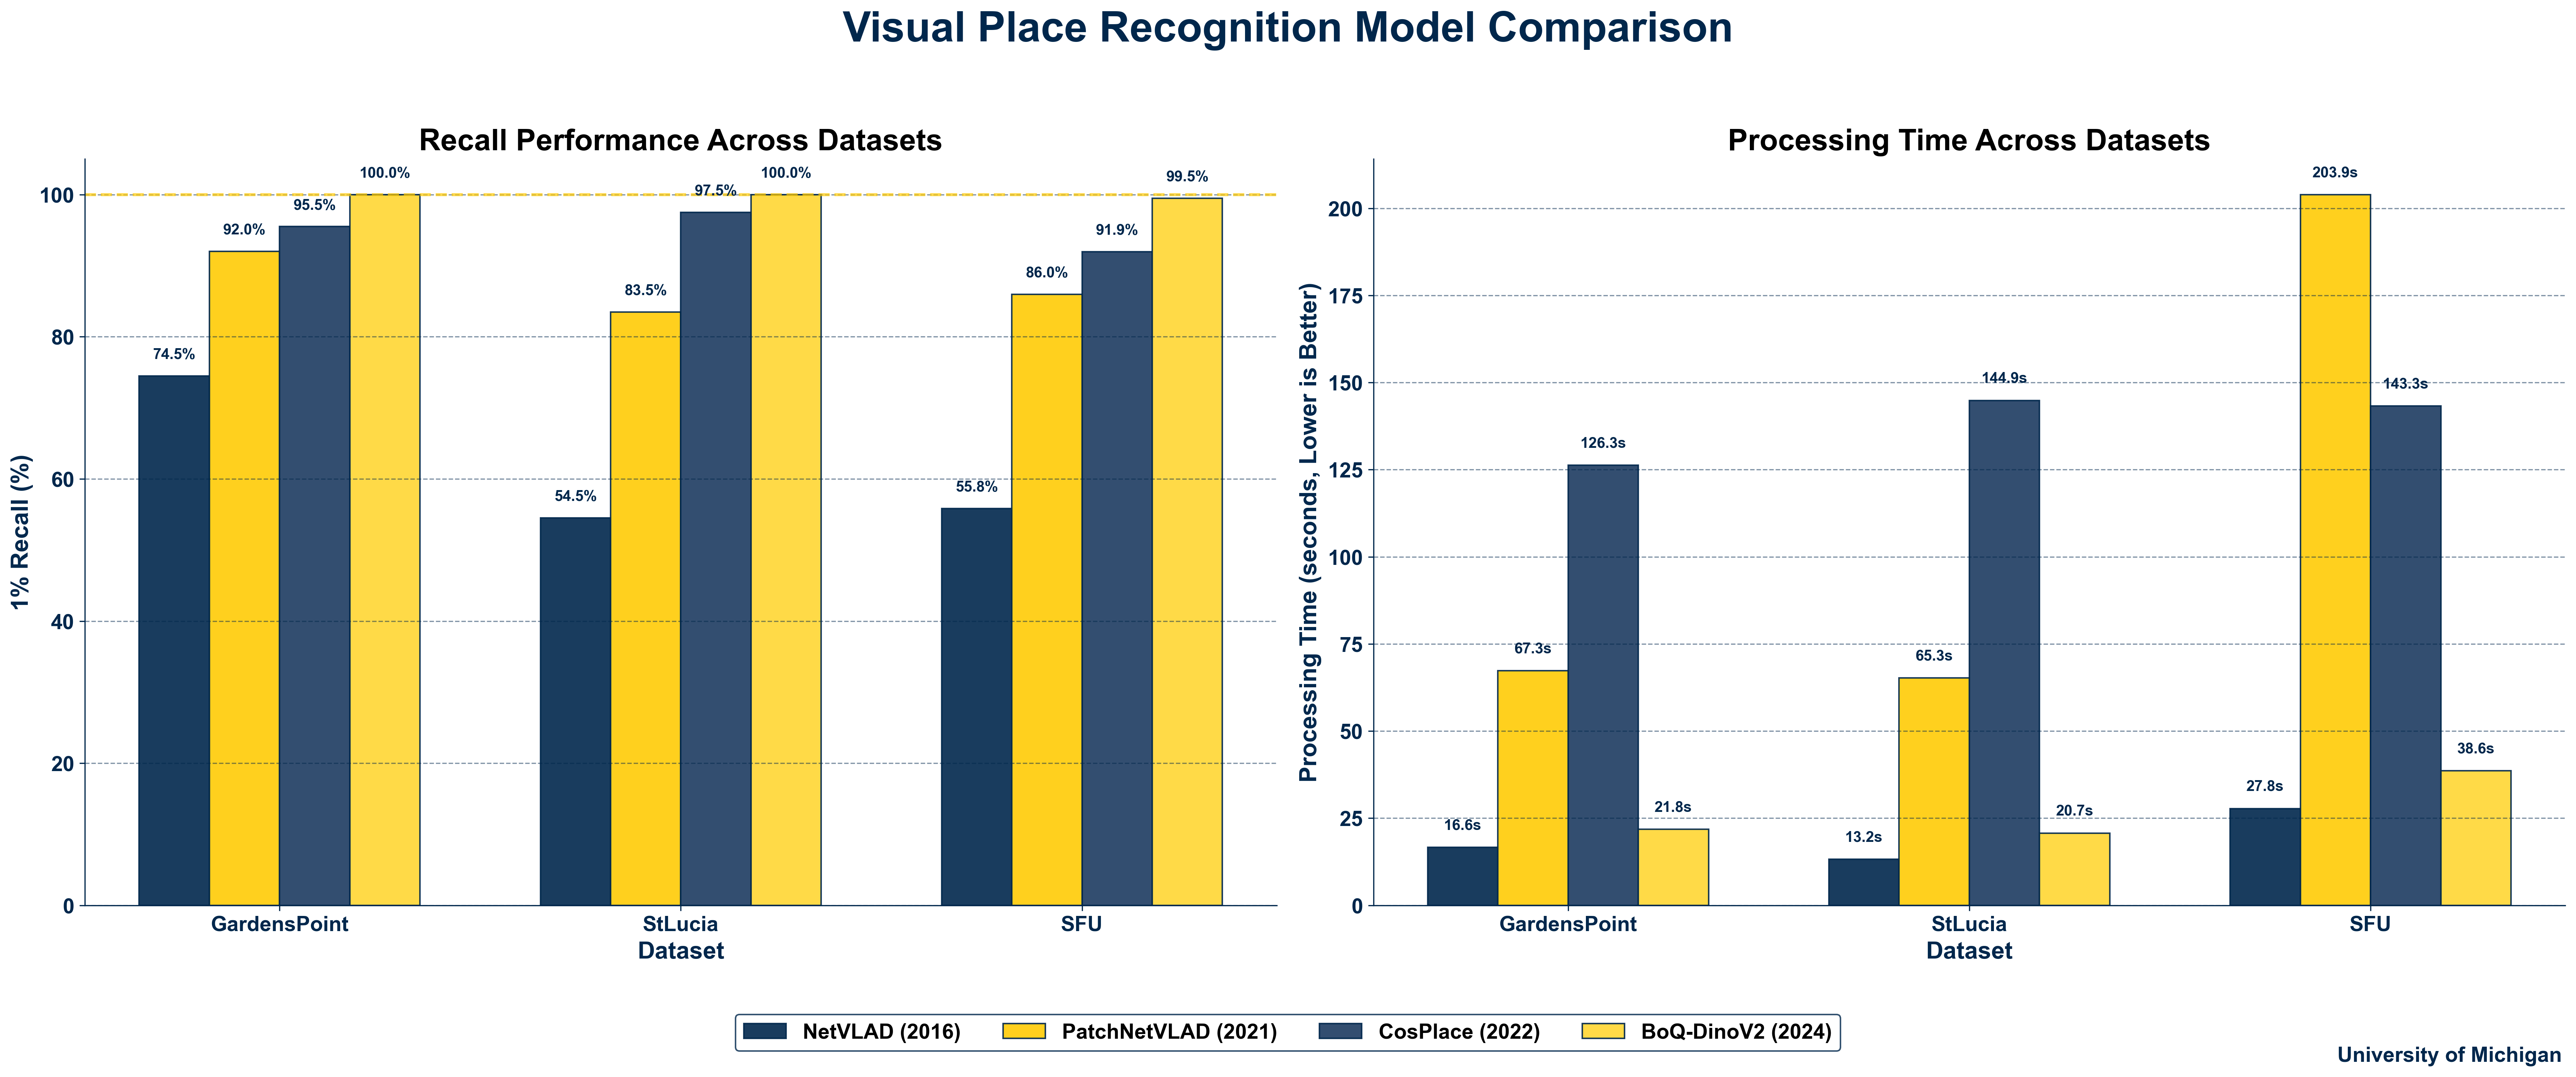

In [ ]:
def create_comparison_charts(results_df, timing_dict):
    """
    Create high-resolution charts for poster presentation showing recall performance,
    timing metrics, and efficiency using University of Michigan colors.
    Models are sorted by their publication year.
    """
    
    # Convert recall values from decimal to percentage
    results_df = results_df * 100  # Convert to percentage
    
    # Set high DPI for high resolution
    plt.rcParams['figure.dpi'] = 300
    
    # University of Michigan official colors
    UMICH_BLUE = '#00274C'
    UMICH_MAIZE = '#FFCB05'
    
    # Create a color palette based on UMich colors
    color_palette = [
        UMICH_BLUE,     
        UMICH_MAIZE,   
        '#1D3B60',      
        '#FFD633',       
        '#3A5273',       
        '#FFE066',  
        '#576F93',     
        '#FFEB99',      
    ]

    # Fonts
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20
    TITLE_SIZE = 24
    
    # Configure font sizes
    plt.rc('font', size=SMALL_SIZE, weight='bold', family='sans-serif')
    plt.rc('axes', titlesize=BIGGER_SIZE, labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)
    plt.rc('legend', fontsize=SMALL_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    
    # Apply UMich style to matplotlib
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    plt.rcParams['axes.edgecolor'] = UMICH_BLUE
    plt.rcParams['axes.labelcolor'] = UMICH_BLUE
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['xtick.color'] = UMICH_BLUE
    plt.rcParams['ytick.color'] = UMICH_BLUE
    
    # Define model years dictionary
    model_years = {
        'NetVLAD': '2016',
        'PatchNetVLAD': '2021',
        'BoQ-DinoV2': '2024',
        'BoQ-ResNet50': '2024',
        'AlexNet': '2012',
        'EigenPlaces': '2023',
        'CosPlace': '2022',
        'HDC-DELF': '2019',
        'SAD': '2021',
        'SuperPoint': '2017',
    }
    
    # Create a dictionary of actual models in our results with their years
    actual_model_years = {}
    for model in results_df.index:
        if model in model_years:
            actual_model_years[model] = model_years[model]
        else:
            actual_model_years[model] = '9999'  # Unknown years go to the end
    
    # Sort models by year
    sorted_models = sorted(actual_model_years.keys(), key=lambda x: (actual_model_years[x], x))
    
    # Reindex results to match the sorted order
    sorted_results_df = results_df.reindex(sorted_models)
    
    # Create timing DataFrame from sorted models
    timing_data = {}
    for model in sorted_models:
        timing_data[model] = {}
        for dataset in sorted_results_df.columns:
            if dataset in timing_dict and model in timing_dict[dataset]:
                timing_data[model][dataset] = timing_dict[dataset][model]['total']
            else:
                timing_data[model][dataset] = np.nan  # Use NaN for missing data
    
    timing_df = pd.DataFrame(timing_data).transpose()
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Setup for recall chart (left)
    n_datasets = len(sorted_results_df.columns)
    n_models = len(sorted_models)
    bar_width = 0.7 / n_models 
    r = np.arange(n_datasets)
    
    # Plot recall bars
    for i, model in enumerate(sorted_models):
        if model in model_years:
            model_with_year = f"{model} ({model_years[model]})"
        else:
            model_with_year = model
        
        color_idx = i % len(color_palette)
        
        ax1.bar(r + i*bar_width - (n_models-1)*bar_width/2, sorted_results_df.loc[model], 
                width=bar_width, label=model_with_year, alpha=0.9,
                color=color_palette[color_idx], edgecolor=UMICH_BLUE, linewidth=1)
    
    # Set recall chart properties with enhanced styling
    ax1.set_xlabel('Dataset', fontweight='bold', fontsize=MEDIUM_SIZE)
    ax1.set_ylabel('1% Recall (%)', fontweight='bold', fontsize=MEDIUM_SIZE)
    ax1.set_title('Recall Performance Across Datasets', fontsize=BIGGER_SIZE, fontweight='bold')
    ax1.set_xticks(r)
    ax1.set_xticklabels(sorted_results_df.columns, fontweight='bold', rotation=0)
    ax1.set_ylim(0, 105)  # Set y-axis limit for percentage (0-105%)
    
    # Use UMich style grid
    ax1.grid(axis='y', linestyle='--', alpha=0.5, color=UMICH_BLUE)
    
    # Add a horizontal line at y=100 to represent perfect recall
    ax1.axhline(y=100.0, linestyle='--', alpha=0.7, color=UMICH_MAIZE, linewidth=2)
    
    # Add percentage labels on top of each bar
    for i, model in enumerate(sorted_models):
        for j, dataset in enumerate(sorted_results_df.columns):
            height = sorted_results_df.loc[model, dataset]
            if not np.isnan(height):  # Skip missing values
                ax1.text(j + i*bar_width - (n_models-1)*bar_width/2, height + 2, 
                         f'{height:.1f}%', ha='center', va='bottom', 
                         fontsize=SMALL_SIZE-4, fontweight='bold', rotation=0,
                         color=UMICH_BLUE)
    
    # Plot timing bars (right)
    for i, model in enumerate(sorted_models):
        if model in model_years:
            model_with_year = f"{model} ({model_years[model]})"
        else:
            model_with_year = model
        
        # Use color from palette
        color_idx = i % len(color_palette)
        
        ax2.bar(r + i*bar_width - (n_models-1)*bar_width/2, timing_df.loc[model], 
                width=bar_width, label=model_with_year, alpha=0.9,
                color=color_palette[color_idx], edgecolor=UMICH_BLUE, linewidth=1)
    
    # Set timing chart properties
    ax2.set_xlabel('Dataset', fontweight='bold', fontsize=MEDIUM_SIZE)
    ax2.set_ylabel('Processing Time (seconds, Lower is Better)', fontweight='bold', fontsize=MEDIUM_SIZE)
    ax2.set_title('Processing Time Across Datasets', fontsize=BIGGER_SIZE, fontweight='bold')
    ax2.set_xticks(r)
    ax2.set_xticklabels(timing_df.columns, fontweight='bold', rotation=0)
    
    ax2.grid(axis='y', linestyle='--', alpha=0.5, color=UMICH_BLUE)
    
    # Add value labels on top of each bar
    for i, model in enumerate(sorted_models):
        for j, dataset in enumerate(timing_df.columns):
            height = timing_df.loc[model, dataset] if model in timing_df.index else np.nan
            if not np.isnan(height):  
                ax2.text(j + i*bar_width - (n_models-1)*bar_width/2, height + 0.02 * ax2.get_ylim()[1], 
                         f'{height:.1f}s', ha='center', va='bottom', 
                         fontsize=SMALL_SIZE-4, fontweight='bold', rotation=0,
                         color=UMICH_BLUE)
    
    # Add box around legend
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), 
               ncol=min(5, n_models), frameon=True, fontsize=MEDIUM_SIZE-2,
               edgecolor=UMICH_BLUE)
    
    # Main figure title for the comparison
    fig.suptitle('Visual Place Recognition Model Comparison', fontsize=TITLE_SIZE+4, 
                 fontweight='bold', color=UMICH_BLUE, y=0.98)
    
    
    fig.text(0.99, 0.01, 'University of Michigan', fontsize=SMALL_SIZE, 
             fontweight='bold', color=UMICH_BLUE, ha='right')
    
    # Adjust layout and save with high DPI
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    vpr_comparison_path = os.path.join(image_data_paths, 'vpr_comparison_with_timing.png')
    vpr_comparison_path_pdf = os.path.join(image_data_paths, 'vpr_comparison_with_timing.pdf')
    plt.savefig(vpr_comparison_path, dpi=600, bbox_inches='tight')
    plt.savefig(vpr_comparison_path_pdf, bbox_inches='tight') 
    plt.show()
    
    # Create a normalized time-efficiency chart (recall/second)
    efficiency_data = defaultdict(dict)
    for dataset in sorted_results_df.columns:
        for model in sorted_models:
            if dataset in timing_dict and model in timing_dict[dataset]:
                recall = sorted_results_df.loc[model, dataset] / 100.0  # Convert back to decimal for calculation
                time_taken = timing_dict[dataset][model]['total']
                if time_taken > 0:
                    efficiency = recall / time_taken  
                    efficiency_data[model][dataset] = efficiency
    
    if not efficiency_data:
        print("No efficiency data available.")
        return
        
    efficiency_df = pd.DataFrame(efficiency_data)
    efficiency_df = efficiency_df.transpose()
    
    # Plot efficiency chart with enhanced styling
    plt.figure(figsize=(18, 10))
    ax = plt.gca()
    r = np.arange(len(efficiency_df.columns))
    
    for i, model in enumerate(sorted_models):
        if model in efficiency_df.index and any(not pd.isna(value) for value in efficiency_df.loc[model]):
            if model in model_years:
                model_with_year = f"{model} ({model_years[model]})"
            else:
                model_with_year = model
            
            color_idx = i % len(color_palette)
            
            values = efficiency_df.loc[model].values if model in efficiency_df.index else np.zeros(len(r))
            plt.bar(r + i*bar_width - (n_models-1)*bar_width/2, values, width=bar_width, 
                    label=model_with_year, alpha=0.9, color=color_palette[color_idx], 
                    edgecolor=UMICH_BLUE, linewidth=1)
    
            for j, val in enumerate(values):
                if not np.isnan(val):
                    plt.text(r[j] + i*bar_width - (n_models-1)*bar_width/2, val + 0.01 * ax.get_ylim()[1], 
                            f'{val:.3f}', ha='center', va='bottom', 
                            fontsize=SMALL_SIZE-2, fontweight='bold',
                            color=UMICH_BLUE)
    
    plt.xlabel('Dataset', fontweight='bold', fontsize=MEDIUM_SIZE)
    plt.ylabel('Efficiency (Recall/Second, Higher is Better)', fontweight='bold', fontsize=MEDIUM_SIZE)
    plt.title('VPR Model Efficiency Comparison', fontsize=BIGGER_SIZE, fontweight='bold', color=UMICH_BLUE)
    plt.xticks(r, efficiency_df.columns, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.5, color=UMICH_BLUE)
    
    # Add box around legend with alpha
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), 
              ncol=min(5, n_models), frameon=True, fontsize=MEDIUM_SIZE-2,
              edgecolor=UMICH_BLUE)
    
    plt.figtext(0.99, 0.01, 'University of Michigan', fontsize=SMALL_SIZE, 
                fontweight='bold', color=UMICH_BLUE, ha='right')
    
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])

    vpr_efficiency_path = os.path.join(image_data_paths, 'vpr_efficiency.png')
    vpr_efficiency_path_pdf = os.path.join(image_data_paths, 'vpr_efficiency.pdf')

    plt.savefig(vpr_efficiency_path, dpi=600, bbox_inches='tight')
    plt.savefig(vpr_efficiency_path_pdf, bbox_inches='tight') 
    plt.show()
    
# Create the visualizations
create_comparison_charts(results_df, timing)